In [1]:
# import all the typical toolboxes...
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from numpy import*
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cantera as ct

import time

# Ignition delay computation
In this example, we will illustrate how to setup and use a constant volume batch reactor. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure.

The reactor (system) is simply an insulated box.

The example here is based on the *official* example from here: https://www.cantera.org/examples/jupyter/reactors/batch_reactor_ignition_delay_NTC.ipynb.html

## Define igintion delay functions

In [2]:
def ignitionDelay(fuel,phi,rxT,rxP,ig_est):
    """
    This function computes the ignition delay for a fuel/condition 
    from the occurence of the peak in species' concentration.
    
    This one outputs both ignition delay and the timehistory.
    """
    # # Create our "gas" object from a mechanism
    # gas = ct.Solution(mech)
    gas.TP = rxT, rxP
    gas.set_equivalence_ratio(phi=phi, fuel=fuel, oxidizer={'o2':1.0, 'n2':3.76})
    # gas()
    
    # Create a batch reactor object and add it to a reactor network
    # In this example, the batch reactor will be the only reactor
    # in the network
    r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
    reactorNetwork = ct.ReactorNet([r])
    
    # now compile a list of all variables for which we will store data
    stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]
    # use the above list to create a DataFrame
    timeHistory = pd.DataFrame(columns=stateVariableNames)
    
    # set initial time to zero
    t = 0
    
    # Tic
    t0 = time.time()
    
    counter = 1;
    while(t < ig_est):
        t = reactorNetwork.step()
        if (counter%10 ==0):
            # We will save every 10th value. Otherwise, this takes too long
            # Note that the species concentrations are mass fractions
            timeHistory.loc[t] = reactorNetwork.get_state()
        counter+=1
    tau = timeHistory['oh'].idxmax()
    # # Calculating the instananeous dT/dt
    # timeHistory['time'] = timeHistory.index
    # timeHistory['dTdt'] = timeHistory['temperature'].diff()/timeHistory['time'].diff()
    # tau = timeHistory['dTdt'].idxmax()
    
    #Toc
    t1 = time.time()
    
    print(f'Ignition delay at {rxT:0.0f} was {tau:0.3e}s and took {t1-t0:0.3e}s')    
    # If you want to save all the data - molefractions, temperature, pressure, etc
    # uncomment the next line
    # timeHistory.to_csv("time_history.csv")
    
    return tau, timeHistory

def ignitionDelay_tonly(fuel,phi,rxT,rxP,ig_est):
    """
    This function computes the ignition delay for a fuel/condition 
    from the occurence of the peak in species' concentration.
    
    This one only outputs the ignition delay.
    """
    # Create our "gas" object from a mechanism
    # gas = ct.Solution(mech)
    gas.TP = rxT, rxP
    gas.set_equivalence_ratio(phi=phi, fuel=fuel, oxidizer={'o2':1.0, 'n2':3.76})
    # gas()
    
    # Create a batch reactor object and add it to a reactor network
    # In this example, the batch reactor will be the only reactor
    # in the network
    r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
    reactorNetwork = ct.ReactorNet([r])
    
    # now compile a list of all variables for which we will store data
    stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]
    # use the above list to create a DataFrame
    timeHistory = pd.DataFrame(columns=stateVariableNames)
    
    # set initial time to zero
    t = 0
    
    # Tic
    t0 = time.time()
    
    counter = 1;
    while(t < ig_est):
        t = reactorNetwork.step()
        if (counter%10 ==0):
            # We will save only every 10th value. Otherwise, this takes too long
            # Note that the species concentrations are mass fractions
            timeHistory.loc[t] = reactorNetwork.get_state()
        counter+=1
    tau = timeHistory['oh'].idxmax()
    # # Calculating the instananeous dT/dt
    # timeHistory['time'] = timeHistory.index
    # timeHistory['dTdt'] = timeHistory['temperature'].diff()/timeHistory['time'].diff()
    # tau = timeHistory['dTdt'].idxmax()
    
    #Toc
    t1 = time.time()
    
    # print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))    
    print(f'Ignition delay at {rxT:0.0f} was {tau:0.3e}s and took {t1-t0:0.3e}s')    
    return tau

### Define the gas
In this example we will choose n-heptane as the gas. For a representative kinetic model, we use the 160 species [mechanism](https://combustion.llnl.gov/archived-mechanisms/alkanes/heptane-reduced-mechanism) by [Seier et al. 2000, Proc. Comb. Inst](http://dx.doi.org/10.1016/S0082-0784&#40;00&#41;80610-4). 

In [3]:
# Define the fuel and conditions
mech = 'nc7red.yaml'
gas = ct.Solution(mech)
fuel = 'nc7h16'
phi = 1
rxT = 600 # Kelvin
rxP = 50*101325 # Pa
est_ign_dly = 1 # estimate in [s]

# Calculate 
tau, timeHistory = ignitionDelay(fuel,phi,rxT,rxP,est_ign_dly)

For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391.0
	Value computed using low-temperature polynomial:  21.83428060093267
	Value computed using high-temperature polynomial: 21.76699500201913

Ignition delay at 600 was 2.728e-01s and took 5.651e+00s


# Plot the result

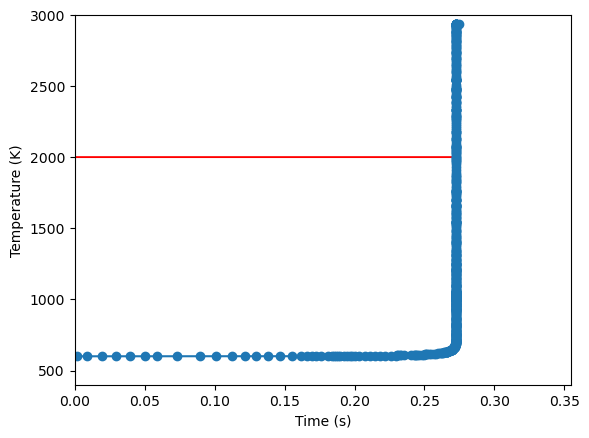

In [4]:
plt.figure()
plt.plot(timeHistory.index, timeHistory['temperature'],'-o')
# plt.plot(timeHistory.index, timeHistory['O2'],'-o')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
# plt.ylabel('$Y_{O2}$')

plt.xlim([0,tau*1.3])
plt.ylim([400,3000])
plt.arrow(0, 2000, tau, 0, width=1, head_width=5,
          head_length=0.002, length_includes_head=True, color='r', shape='full')
plt.annotate(r'$Ignition Delay: \tau_{ign}$', xy=(10,1800), xytext=(10,1800), fontsize=16);
plt.show()

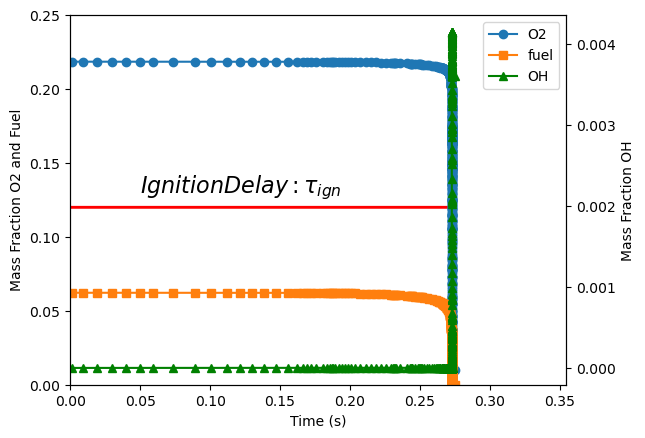

In [5]:
fig,ax1 = plt.subplots()
ax1.plot(timeHistory.index, timeHistory['o2'],'-o',label='O2')
ax1.plot(timeHistory.index, timeHistory[fuel],'-s',label='fuel')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Mass Fraction O2 and Fuel')
ax1.set_ylim([0,0.25])
plt.arrow(0, 0.12, tau, 0, width=0.001, head_width=0.001,
          head_length=0.002, length_includes_head=True, color='r', shape='full')
plt.annotate(r'$Ignition Delay: \tau_{ign}$', xy=(0.05,0.13), xytext=(0.05, 0.13), fontsize=16)
#
ax2 = ax1.twinx()
ax2.plot(timeHistory.index, timeHistory['oh'],'-g^',label='OH')
ax2.set_ylabel('Mass Fraction OH')
#
plt.xlim([0,tau*1.3])
# combine the legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper right')
# show plot
plt.show()

# Illustration : Ignition Delay vs. Inverse Temperature

In [6]:
# Make a list of all the temperatures we would like to run simulations at
T = hstack((arange(1500, 1050, -100), arange(1050, 650, -50)))

est_ig_dly = ones_like(T, dtype=float)
# Make time adjustments for the highest and lowest temperatures. 
# This we do empirically...
est_ig_dly[:10] = .001
est_ig_dly[-10:6] = 0.01
est_ig_dly[-6:-3] = 0.1
est_ig_dly[-2:] = 1

# Now create a dataFrame out of these
ignitionDelays = pd.DataFrame(data={'T':T})
ignitionDelays['ignDelay'] = nan

tau = {}

# Now, run the ignition delay calc for all the temps...
for i, temperature in enumerate(T):
    tau = ignitionDelay_tonly(fuel,phi,T[i],rxP,est_ig_dly[i])
    ignitionDelays.at[i,'ignDelay'] = tau

Ignition delay at 1500 was 4.893e-06s and took 2.803e+00s
Ignition delay at 1400 was 1.182e-05s and took 3.132e+00s
Ignition delay at 1300 was 3.023e-05s and took 3.067e+00s
Ignition delay at 1200 was 8.079e-05s and took 3.188e+00s
Ignition delay at 1100 was 2.459e-04s and took 3.321e+00s
Ignition delay at 1050 was 4.288e-04s and took 3.418e+00s
Ignition delay at 1000 was 5.677e-04s and took 3.246e+00s
Ignition delay at 950 was 4.444e-04s and took 3.878e+00s
Ignition delay at 900 was 3.413e-04s and took 4.270e+00s
Ignition delay at 850 was 3.867e-04s and took 4.409e+00s
Ignition delay at 800 was 7.034e-04s and took 4.642e+00s
Ignition delay at 750 was 1.897e-03s and took 4.523e+00s
Ignition delay at 700 was 7.060e-03s and took 4.688e+00s


# Figure: ignition delay ($\tau$) vs. the inverse of temperature ($\frac{1000}{T}$)

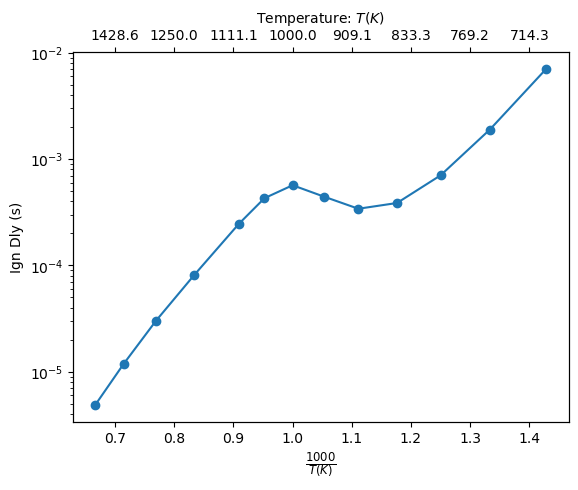

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(1000/ignitionDelays['T'], ignitionDelays['ignDelay'],'o-')
plt.yscale('log')
ax.set_ylabel(r'Ign Dly (s)')
ax.set_xlabel(r'$\frac{1000}{T (K)}$', fontsize=12)

# Add a second axis on top to plot the temperature for better readability
ax2 = ax.twiny()
ticks = ax.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels((1000/ticks).round(1))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel(r'Temperature: $T(K)$');